In [50]:
# librerie
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [51]:
# riproducibilità
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [52]:
# configurazione
image_size = 224 # dimensione a cui ridimensionare ogni immagine
batch_size = 32  # batch size per i DataLoader
n_components = 2342 # componenti principali che spiegano l 95% della soglia
noise_std = 0.05
# valori diversi di noise_std provati [0.0, 0.01, 0.05, 0.1, 0.2, 0.3]
train_ratio, val_ratio = 0.7, 0.15  # percentuali per suddividere in train/val/test
epochs = 1 # epoche training, 100

pretty_labels = ['adenocarcinoma', 'benigno', 'carcinoma squamoso']  # nomi delle classi più leggibili

In [53]:
# percorsi utili
base_dir = os.getcwd()  # percorso base
# percorso per salvare output
output_folder = os.path.join(base_dir, "pca_outputs")
os.makedirs(output_folder, exist_ok=True) # crea se non esiste
log_txt_path = os.path.join(output_folder, "classification_reports.txt")
save_path = os.path.join(output_folder, f'pca_data_{n_components}_{noise_std}.pth')
experiment_name = os.path.splitext(os.path.basename(save_path))[0]

In [54]:
# caricamento dati
data_dict = torch.load(save_path, weights_only=False) # dati pre-elaborati (PCA) salvati in precedenza
X_train = torch.tensor(data_dict['train_data'], dtype=torch.float32)
y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)
X_val = torch.tensor(data_dict['val_data'], dtype=torch.float32)
y_val = torch.tensor(data_dict['val_labels'], dtype=torch.long)
X_test = torch.tensor(data_dict['test_data'], dtype=torch.float32)
y_test = torch.tensor(data_dict['test_labels'], dtype=torch.long)

C:\Users\noemi\AppData\Local\Temp\ipykernel_18332\1917817803.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(data_dict['train_labels'], dtype=torch.long)


In [55]:
# data_loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [56]:
# modello flessibile
class FlexibleNet(nn.Module):  # rete neurale FC, configurabile (layer, dropout, batchnorm)
    def __init__(self, input_dim, hidden_dims, output_dim, use_batchnorm=False, dropout=0.0):
        super().__init__()
        layers = []
        last_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            last_dim = hidden_dim
        layers.append(nn.Linear(last_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [57]:
def specificity_score(y_true, y_pred, average='macro'):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    specificities = []

    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        specificities.append(specificity)

    if average == 'macro':
        return np.mean(specificities)
    elif average == 'none':
        return specificities
    else:
        raise ValueError("average must be 'macro' or 'none'")

In [58]:
# funzione di training
def train_model(model, train_loader, val_loader, criterion, optimizer, use_early_stopping=True, patience=10):
    best_val_loss = float('inf')
    trigger_times = 0
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            correct += (output.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = 100 * correct / total

        model.eval()
        val_correct, val_total = 0, 0
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
                val_correct += (output.argmax(1) == y_batch).sum().item()
                val_total += y_batch.size(0)
        val_acc = 100 * val_correct / val_total

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print("Early stopping triggered.")
                    break

    if use_early_stopping:
        model.load_state_dict(best_model_state)
    return model, history

In [ ]:
results = []
summary = []

# funzione di cross-validation
def cross_validate_model(config, X_data, y_data, X_test, y_test, k=5, config_id=None):
    print(f"\nCross-validation model: {config}")
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    all_y_true, all_y_pred = [], []
    all_y_test_true, all_y_test_pred = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data), 1):
        print(f"\nFold {fold}/{k}")
        X_train_cv, y_train_cv = X_data[train_idx], y_data[train_idx]
        X_val_cv, y_val_cv = X_data[val_idx], y_data[val_idx]

        train_loader_cv = DataLoader(TensorDataset(X_train_cv, y_train_cv), batch_size=batch_size, shuffle=True)
        val_loader_cv = DataLoader(TensorDataset(X_val_cv, y_val_cv), batch_size=batch_size)

        model = FlexibleNet(n_components, config['hidden_dims'], len(pretty_labels),
                            use_batchnorm=config['batchnorm'], dropout=config['dropout'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        model, _ = train_model(model, train_loader_cv, val_loader_cv, criterion, optimizer,
                               use_early_stopping=config['early_stopping'])

        # Validation evaluation
        model.eval()
        y_true_fold, y_pred_fold = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader_cv:
                output = model(X_batch)
                preds = output.argmax(1)
                y_true_fold.extend(y_batch.tolist())
                y_pred_fold.extend(preds.tolist())

        acc = 100 * np.mean(np.array(y_true_fold) == np.array(y_pred_fold))
        fold_accuracies.append(acc)
        all_y_true.extend(y_true_fold)
        all_y_pred.extend(y_pred_fold)

        report_fold = classification_report(y_true_fold, y_pred_fold, target_names=pretty_labels)
        print(f"Fold {fold} Accuracy: {acc:.2f}%")
        print(report_fold)

        fold_title = f"[{experiment_name}] Config {config_id} - Fold {fold}"
        with open(log_txt_path, "a") as f:
            f.write(f"{fold_title}\n{report_fold}\n")
            f.write(f"Fold Accuracy: {acc:.2f}%\n")
            f.write("-" * 80 + "\n")

        # Test evaluation
        model.eval()
        y_test_true, y_test_pred = [], []
        with torch.no_grad():
            test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                preds = output.argmax(1)
                y_test_true.extend(y_batch.tolist())
                y_test_pred.extend(preds.tolist())

        # Accumula per Confusion Matrix cumulativa finale
        all_y_test_true.extend(y_test_true)
        all_y_test_pred.extend(y_test_pred)

        test_acc = 100 * np.mean(np.array(y_test_true) == np.array(y_test_pred))
        test_precision = precision_score(y_test_true, y_test_pred, average='macro')
        test_recall = recall_score(y_test_true, y_test_pred, average='macro')
        test_f1 = f1_score(y_test_true, y_test_pred, average='macro')
        test_specificity = specificity_score(y_test_true, y_test_pred)
        test_spec_per_class = specificity_score(y_test_true, y_test_pred, average='none')

        test_report_dict = classification_report(y_test_true, y_test_pred, target_names=pretty_labels, output_dict=True)
        test_class_metrics = {}
        for class_name in pretty_labels:
            test_class_metrics[f'test_precision_{class_name}'] = test_report_dict[class_name]['precision']
            test_class_metrics[f'test_recall_{class_name}'] = test_report_dict[class_name]['recall']
            test_class_metrics[f'test_f1_{class_name}'] = test_report_dict[class_name]['f1-score']

        test_cm = confusion_matrix(y_test_true, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(test_cm, annot=True, fmt='d',
                    xticklabels=pretty_labels,
                    yticklabels=pretty_labels,
                    cmap='Greens')
        plt.title(f"Confusion Matrix TEST - Fold {fold}")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        test_cm_path = os.path.join(output_folder, f"{experiment_name}_conf_matrix_TEST_fold_{fold}_config_{config_id}.png")
        plt.savefig(test_cm_path)
        plt.close()

        with open(log_txt_path, "a") as f:
            f.write(f"[{experiment_name}] Config {config_id} - Fold {fold} - TEST SET METRICS\n")
            f.write(classification_report(y_test_true, y_test_pred, target_names=pretty_labels))
            f.write(f"Test Accuracy: {test_acc:.2f}%\n")
            f.write("-" * 80 + "\n")

    # Cumulative metrics on validation folds
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)

    precision = precision_score(all_y_true, all_y_pred, average='macro')
    recall = recall_score(all_y_true, all_y_pred, average='macro')
    f1 = f1_score(all_y_true, all_y_pred, average='macro')
    specificity_macro = specificity_score(all_y_true, all_y_pred)
    specificity_per_class = specificity_score(all_y_true, all_y_pred, average='none')

    report_dict = classification_report(all_y_true, all_y_pred, target_names=pretty_labels, output_dict=True)
    class_metrics = {}
    for class_name in pretty_labels:
        class_metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        class_metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        class_metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    final_title = f"[{experiment_name}] Config {config_id} - SUMMARY"
    with open(log_txt_path, "a") as f:
        f.write(f"{final_title}\n")
        f.write(f"Mean Fold Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}\n")
        f.write("=" * 100 + "\n")

    print(f"\n Config {config_id} - CV Mean Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")

    # Confusion Matrix cumulativa - validation
    cumulative_cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cumulative_cm, annot=True, fmt='d',
                xticklabels=pretty_labels,
                yticklabels=pretty_labels,
                cmap='Blues')
    plt.title("Confusion Matrix CUMULATIVA - VALIDAZIONE")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    cumulative_path = os.path.join(output_folder, f"{experiment_name}_conf_matrix_cumulative_config_{config_id}.png")
    plt.savefig(cumulative_path)
    plt.close()

    # Confusion Matrix cumulativa - test
    final_test_cm = confusion_matrix(all_y_test_true, all_y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(final_test_cm, annot=True, fmt='d',
                xticklabels=pretty_labels,
                yticklabels=pretty_labels,
                cmap='Oranges')
    plt.title("Confusion Matrix CUMULATIVA - TEST")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    final_test_cm_path = os.path.join(output_folder, f"{experiment_name}_conf_matrix_cumulative_TEST_config_{config_id}.png")
    plt.savefig(final_test_cm_path)
    plt.close()

    # Aggiungi tutte le metriche al summary
    summary.append({
        'config_id': config_id,
        'hidden_dims': config['hidden_dims'],
        'dropout': config['dropout'],
        'batchnorm': config['batchnorm'],
        'early_stopping': config['early_stopping'],
        'cross_val': True,
        'accuracy': mean_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity_macro,
        'specificity_per_class': list(specificity_per_class), 
        **class_metrics,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1_score': test_f1,
        'test_specificity': test_specificity,
        'test_specificity_per_class': list(test_spec_per_class), 
        'conf_matrix': list(cumulative_cm),           
        'conf_matrix_test': list(final_test_cm),       
        **test_class_metrics
    })




In [60]:
configurations = [
     {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [128], 'batchnorm': False, 'dropout': 0.1, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [128, 64], 'batchnorm': False, 'dropout': 0.3, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [128, 64], 'batchnorm': True, 'dropout': 0.3, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [256, 128], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [512, 256, 128], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [512, 256, 128], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [1024, 512, 256], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [1024, 512, 256, 128], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [1024, 512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [1024, 512, 256, 128, 64], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.5, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
    #{'hidden_dims': [1024, 512, 256, 128, 64, 32], 'batchnorm': True, 'dropout': 0.7, 'early_stopping': True, 'cross_val': True},
    # {'hidden_dims': [1024, 512, 256, 128, 64, 32, 16], 'batchnorm': True, 'dropout': 0.6, 'early_stopping': True, 'cross_val': True},
]

In [ ]:
for i, config in enumerate(configurations, 1):
    print(f"\n[{experiment_name}] Config {i}: {config}")
    if config.get("cross_val", False):
        cross_validate_model(config, torch.cat([X_train, X_val]), torch.cat([y_train, y_val]), X_test, y_test, k=5, config_id=i)
    else:
        model = FlexibleNet(n_components, config['hidden_dims'], len(pretty_labels),
                            use_batchnorm=config['batchnorm'], dropout=config['dropout'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        model, history = train_model(model, train_loader, val_loader, criterion, optimizer,
                                     use_early_stopping=config['early_stopping'])

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                preds = output.argmax(1)
                y_true.extend(y_batch.tolist())
                y_pred.extend(preds.tolist())

        test_acc = 100 * np.mean(np.array(y_true) == np.array(y_pred))
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        report_txt = classification_report(y_true, y_pred, target_names=pretty_labels)
        cm = confusion_matrix(y_true, y_pred)
        specificity_macro = specificity_score(y_true, y_pred, average='macro')
        specificity_per_class = specificity_score(y_true, y_pred, average='none')

        # 🆕 Calcolo delle metriche per classe
        report_dict = classification_report(y_true, y_pred, target_names=pretty_labels, output_dict=True)
        class_metrics = {}
        for class_name in pretty_labels:
            class_metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
            class_metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
            class_metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

        print(report_txt)
        print("Confusion Matrix:")
        print(cm)
        print(f"Specificity (macro): {specificity_macro:.4f}")
        for label, spec in zip(pretty_labels, specificity_per_class):
            print(f"Specificity [{label}]: {spec:.4f}")

        title = f"[{experiment_name}] Config {i}"
        with open(log_txt_path, "a") as f:
            f.write(f"{title}\nTest Accuracy: {test_acc:.2f}%\n")
            f.write(report_txt + "\n")
            f.write("Confusion Matrix:\n" + np.array2string(cm) + "\n")
            f.write("Specificities:\n")
            for label, spec in zip(pretty_labels, specificity_per_class):
                f.write(f"{label}: {spec:.4f}\n")
            f.write("=" * 80 + "\n")

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=pretty_labels, yticklabels=pretty_labels, cmap='Blues')
        plt.title(f"Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(os.path.join("pca_outputs", f"{experiment_name}_conf_matrix_config_{i}.png"))
        plt.show()

        summary.append({
            'config_id': i,
            'hidden_dims': config['hidden_dims'],
            'dropout': config['dropout'],
            'batchnorm': config['batchnorm'],
            'early_stopping': config['early_stopping'],
            'cross_val': False,
            'accuracy': test_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'specificity': specificity_macro,
            'specificity_per_class': list(specificity_per_class), # tolgo .tolist() se traino una sola configurazione
            'conf_matrix': list(cm), # tolgo .tolist() se traino una sola configurazione
            **class_metrics  #  Inserisce precision, recall, f1 per ogni classe
        })
 
        


[pca_data_2342_0.05] Config 1: {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True}

Cross-validation model: {'hidden_dims': [64], 'batchnorm': False, 'dropout': 0.0, 'early_stopping': True, 'cross_val': True}

Fold 1/5


Epoch 01 | Train Acc: 67.25% | Val Acc: 71.02%
Fold 1 Accuracy: 71.02%
                    precision    recall  f1-score   support

    adenocarcinoma       0.63      0.53      0.58       861
           benigno       0.85      0.93      0.89       855
carcinoma squamoso       0.63      0.67      0.65       862

          accuracy                           0.71      2578
         macro avg       0.70      0.71      0.70      2578
      weighted avg       0.70      0.71      0.70      2578


Fold 2/5
Epoch 01 | Train Acc: 67.99% | Val Acc: 71.06%
Fold 2 Accuracy: 71.06%
                    precision    recall  f1-score   support

    adenocarcinoma       0.61      0.59      0.60       861
           benigno       0.89      0.92      0.91       855
carcinoma squamoso       0.62      0.62      0.62       862

          accuracy                           0.71      2578
         macro avg       0.71      0.71      0.71      2578
      weighted avg       0.71      0.71      0.71      2578


F

In [62]:
summary_df = pd.DataFrame(summary)
summary_df['specificity_per_class'] = summary_df['specificity_per_class'].apply(
    lambda x: ','.join(f"{v:.4f}" for v in x) if isinstance(x, (list, np.ndarray)) else str(x)
)
summary_df['test_specificity_per_class'] = summary_df['test_specificity_per_class'].apply(
    lambda x: ','.join(f"{v:.4f}" for v in x) if isinstance(x, (list, np.ndarray)) else str(x)
)
summary_df.to_csv(os.path.join("pca_outputs", f"{experiment_name}_summary.csv"), index=False)

with open(os.path.join("pca_outputs", f"{experiment_name}_summary.txt"), 'w') as f:
    for row in summary:
        f.write(f"Config {row['config_id']} | Acc: {row['accuracy']:.2f}% | Dropout: {row['dropout']} | Layers: {row['hidden_dims']}\n")

In [63]:
print(summary_df.columns)

Index(['config_id', 'hidden_dims', 'dropout', 'batchnorm', 'early_stopping',
       'cross_val', 'accuracy', 'precision', 'recall', 'f1_score',
       'specificity', 'specificity_per_class', 'precision_adenocarcinoma',
       'recall_adenocarcinoma', 'f1_adenocarcinoma', 'precision_benigno',
       'recall_benigno', 'f1_benigno', 'precision_carcinoma squamoso',
       'recall_carcinoma squamoso', 'f1_carcinoma squamoso', 'test_accuracy',
       'test_precision', 'test_recall', 'test_f1_score', 'test_specificity',
       'test_specificity_per_class', 'conf_matrix', 'conf_matrix_test',
       'test_precision_adenocarcinoma', 'test_recall_adenocarcinoma',
       'test_f1_adenocarcinoma', 'test_precision_benigno',
       'test_recall_benigno', 'test_f1_benigno',
       'test_precision_carcinoma squamoso', 'test_recall_carcinoma squamoso',
       'test_f1_carcinoma squamoso'],
      dtype='object')


In [64]:
print(np.bincount(y_test.numpy()))

[734 728 788]


In [65]:
#solo le configurazioni con cross_val=True
summary_df = summary_df[summary_df['cross_val'] == True]

# eseguzione del plot solo se ci sono 15 configurazioni 
if len(summary_df) == 15 and len(summary_df) == 15:  
    x = np.arange(len(summary_df))
    bar_width = 0.16

    plt.figure(figsize=(16, 7))
    plt.bar(x - 2 * bar_width, summary_df['test_accuracy'] / 100, width=bar_width, label='Accuracy', color='#7F8C8D')
    plt.bar(x - 1 * bar_width, summary_df['test_precision'], width=bar_width, label='Precision', color='#ECD165')
    plt.bar(x, summary_df['test_recall'], width=bar_width, label='Recall', color='#57A5D9')
    plt.bar(x + 1 * bar_width, summary_df['test_f1_score'], width=bar_width, label='F1 Score', color='#9B59B6')
    plt.bar(x + 2 * bar_width, summary_df['test_specificity'], width=bar_width, label='Specificity', color='#A3E4D7')

    plt.xlabel("Modelli")
    plt.ylabel("Valore (0-1)")
    plt.title(f"Confronto metriche per Configurazione - PCA {n_components}_{noise_std}")
    plt.xticks(x, [f"Modello {cid}" for cid in summary_df['config_id']], rotation=45)
    plt.ylim(0.7, 0.78)
    plt.legend()
    plt.yticks(np.arange(0.7, 0.8, 0.01))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "metrics_comparison.png"))
    plt.show()
else:
    print("Nessun grafico generato.")


Nessun grafico generato.


AttributeError: module 'os' has no attribute 'join'

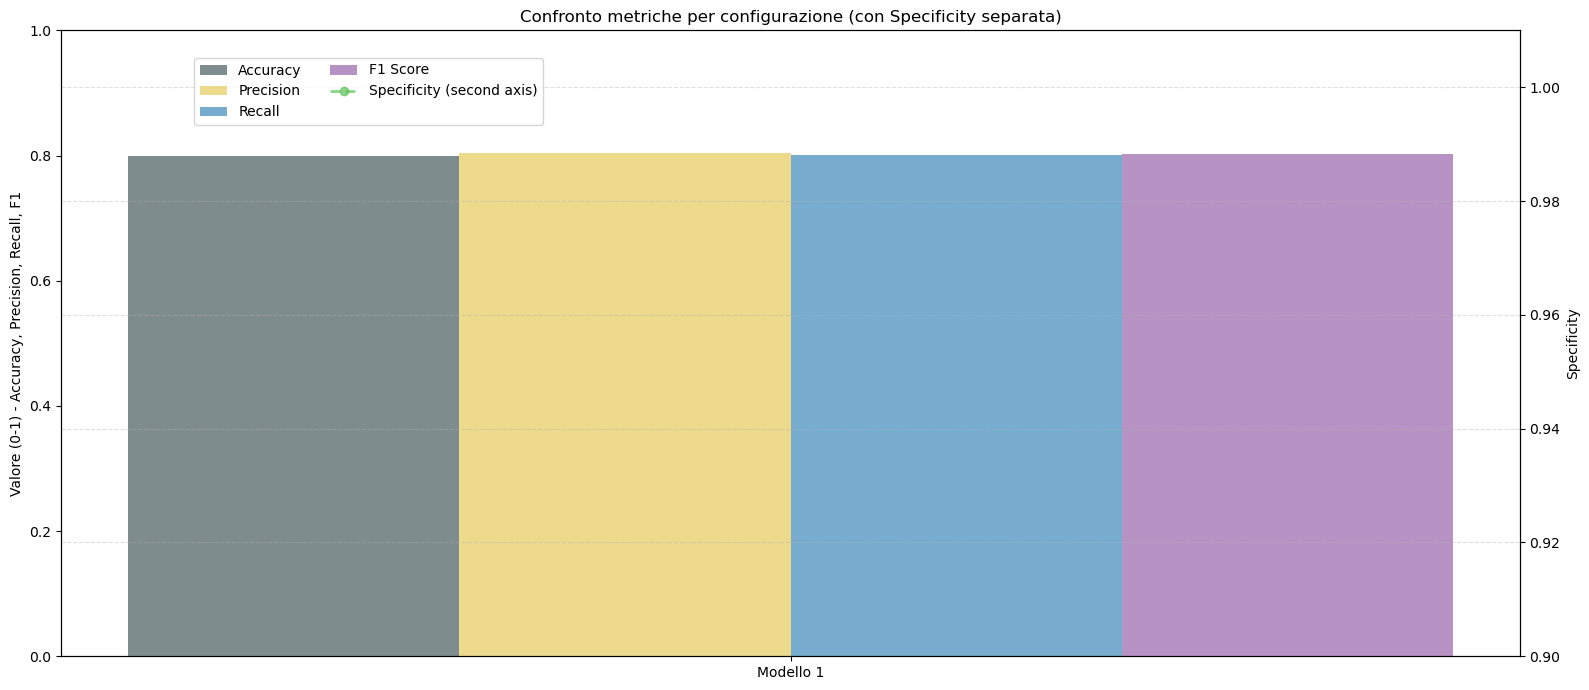

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 7))

x = np.arange(len(summary_df))
bar_width = 0.18

# Prima y-axis
ax1.bar(x - 1.5 * bar_width, summary_df['test_accuracy'] / 100, width=bar_width, label='Accuracy', color='#7F8C8D')
ax1.bar(x - 0.5 * bar_width, summary_df['test_precision'], width=bar_width, label='Precision', color="#E7CD64BC")
ax1.bar(x + 0.5 * bar_width, summary_df['test_recall'], width=bar_width, label='Recall', color="#448DBEB9")
ax1.bar(x + 1.5 * bar_width, summary_df['test_f1_score'], width=bar_width, label='F1 Score', color="#A275B4C8")
ax1.set_ylabel("Valore (0-1) - Accuracy, Precision, Recall, F1")
ax1.set_ylim(0.0, 1.0)

# Seconda y-axis
ax2 = ax1.twinx()
ax2.plot(x, summary_df['specificity'], 'o--', color="#66C763C0", label='Specificity (second axis)', linewidth=2, markersize=6)
ax2.set_ylabel("Specificity")
ax2.set_ylim(0.9, 1.01)

plt.xticks(x, [f"Modello {cid}" for cid in summary_df['config_id']], rotation=45)
fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.92), ncol=2)
plt.title("Confronto metriche per configurazione (con Specificity separata)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig(os.path.join(output_folder, "metrics_comparison_specificity.png"))
plt.show()

AttributeError: module 'os' has no attribute 'join'

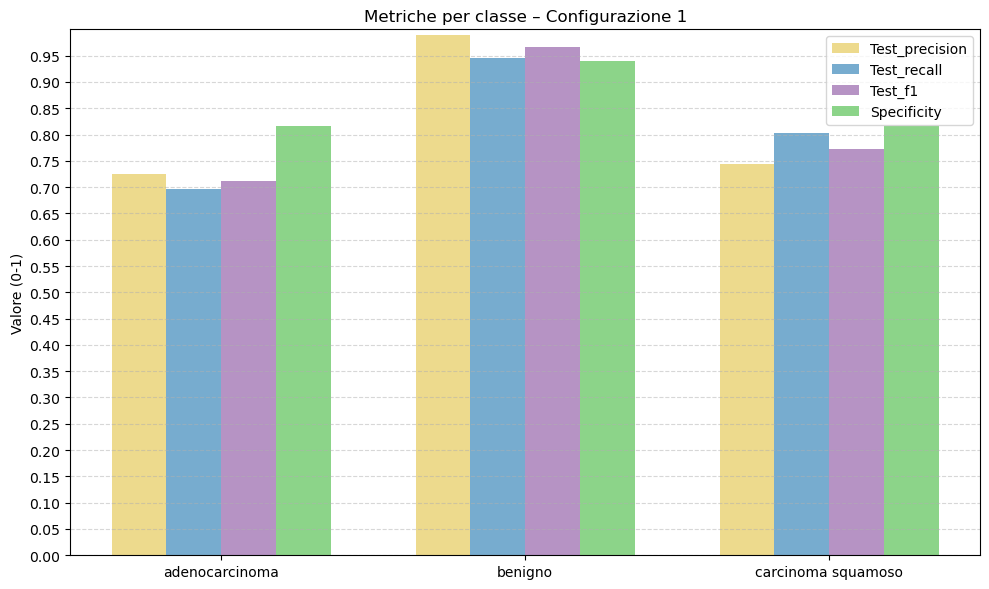

In [ ]:
# configurazione da visualizzare (indice del config_id)
selected_config_id = 1

# filtro dataframe
row = summary_df[summary_df['config_id'] == selected_config_id].iloc[0]

# estrazione metriche per classe
metrics = ['test_precision', 'test_recall', 'test_f1']
data = {m: [row[f'{m}_{cls}'] for cls in pretty_labels] for m in metrics}

# aggiuinta specificity per classe
data['specificity'] = row['specificity_per_class'] if isinstance(row['specificity_per_class'], list) else eval(row['specificity_per_class'])

# plot
x = np.arange(len(pretty_labels))
bar_width = 0.18

plt.figure(figsize=(10, 6))
colors = ["#E7CD64BC", "#448DBEB9", "#A275B4C8", "#66C763C0"]  # oro, blu, lilla, verde acqua

for i, metric in enumerate(data.keys()):
    plt.bar(x + i * bar_width - 1.5 * bar_width, data[metric], width=bar_width, label=metric.capitalize(), color=colors[i])

plt.xticks(x, pretty_labels)
plt.ylim(0.0, 1.0)
plt.ylabel("Valore (0-1)")
plt.title(f"Metriche per classe – Configurazione {selected_config_id}")
plt.yticks(np.arange(0.0, 1, 0.05))  # ogni 0.01 tra 0.7 e 0.8
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "metrics_comparison_per_class.png"))
plt.show()
